In [4]:
import torch
import torch.nn as nn

import collections
from typing import List, Tuple

import pyro
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import CosineAnnealingWarmRestarts

import numpy as np
import matplotlib.pyplot as plt
import scipy.special as ssp

import umap

from torch.optim import SGD
from torch.distributions.utils import probs_to_logits
from torch.utils.data import DataLoader, TensorDataset

In [3]:
import drvish.util.plot as drplt

from drvish.data import split_dataset, split_labeled_dataset
from drvish.train import train_until_plateau, evaluate, AggMo, train, evaluate
from drvish.util import build_dr_dataset

from drvish.models import NBVAE, DRNBVAE

from drvish.models.modules import LinearMultiBias

In [5]:
n_classes = 8
n_latent = 8
n_cells_per_class = 512
n_features = 128
n_drugs = 2
n_conditions = 8

In [6]:
exp, classes, progs, z, doses, drs, lib_size, umis = build_dr_dataset(
    n_classes=n_classes,
    n_latent=n_latent,
    n_cells_per_class=n_cells_per_class,
    n_features=n_features,
    n_drugs=n_drugs,
    n_conditions=n_conditions,
    library_kw={'loc': 5.5, 'scale': 0.5},
    class_kw={"scale": 2.0, "sparsity": 0.5}
)

In [ ]:
drs[0].shape

In [7]:
drplt.make_grid(
    *[drplt.drug_response(d.reshape(-1, n_conditions), dos, classes)
     for d,dos in zip(drs,doses)],
    n_cols=2
)


alt.VConcatChart(...)

In [ ]:
umis.shape, exp.shape, drs[0].shape

In [8]:
te_umis = umis[:, 4:, :]
te_exp = exp[:, 4:, :]
te_classes = classes[classes >= 4]
te_drs = [d[:, 4:, :] for d in drs]

umis = umis[:, :4, :]
exp = exp[:, :4, :]
classes = classes[classes < 4]
drs = [d[:, :4, :] for d in drs]

In [9]:
umis_flat = umis.reshape((4 * n_cells_per_class, n_features))

dr_means = torch.stack([torch.tensor(ssp.logit(d).mean(0)) for d in drs], dim=2)

In [ ]:
umi_t = torch.tensor(umis_flat, dtype=torch.float)

lmb = LinearMultiBias(n_features, n_drugs, n_conditions, 5.0, 10.0)
lmb.linear(umi_t).shape


lmb(umi_t, torch.tensor(classes))[:,:,0]

response = (lmb.linear(umi_t)[..., None, :] + lmb.biases)
response.shape

In [10]:
tr_dl, val_dl = split_labeled_dataset(
    torch.tensor(umis_flat, dtype=torch.float),
    labels=classes,
    target=dr_means, 
    batch_size=128,
    train_p=0.875,
)

In [ ]:
tr_dl, val_dl = split_dataset(
    torch.tensor(umis_flat, dtype=torch.float),
    batch_size=128,
    train_p=0.875,
)

In [ ]:
pyro.clear_param_store()
nbvae = NBVAE(
    n_input=n_features,
    n_latent=16,
    layers=[256, 256],
)

In [11]:
pyro.clear_param_store()
nbvae = DRNBVAE(
    n_input=n_features,
    n_classes=n_classes - 4,
    n_drugs=n_drugs,
    n_conditions=n_conditions,
    n_latent=8,
    layers=[128],
    lam_scale=5.0,
)

In [12]:
scheduler = CosineAnnealingWarmRestarts(
    {
        "optimizer": AggMo,
        "T_0": 80,
        "eta_min": 1e-6,
        "optim_args": {"lr": 1e-4, "betas": [0.0, 0.9, 0.99]},
    },
    {"clip_norm": 10.0}
)
svi = SVI(nbvae.model, nbvae.guide, scheduler, loss=Trace_ELBO())

In [13]:
train_loss, val_loss = train_until_plateau(svi, scheduler, tr_dl, val_dl, verbose=True)

[epoch 000]  average training loss: 205431.04196
[epoch 080]  average training loss: 31902.56306
[epoch 160]  average training loss: 31162.51569
[epoch 240]  average training loss: 31039.99355


In [ ]:
train_loss2, val_loss2 = train_until_plateau(svi, scheduler, tr_dl, val_dl, verbose=True)

train_loss.extend(train_loss2)
val_loss.extend(val_loss2)

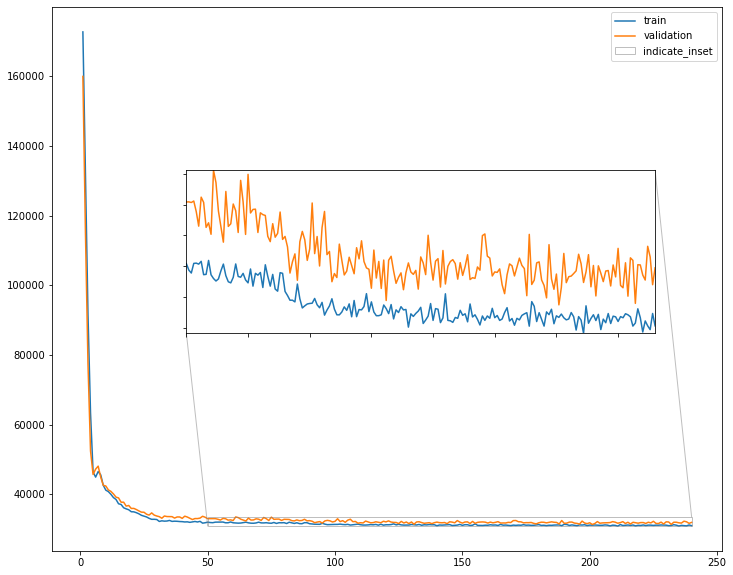

In [14]:
fig,ax = plt.subplots(1, 1, figsize=(12, 10))

k = 50

x = np.arange(len(train_loss))
ax.plot(x[1:], train_loss[1:], label="train")
ax.plot(x[1:], val_loss[1:], label="validation")

axin = ax.inset_axes([0.2, 0.4, 0.7, 0.3])

axin.plot(x[k:], train_loss[k:], label="train")
axin.plot(x[k:], val_loss[k:], label="validation")
axin.autoscale(tight=True)
b = ax.indicate_inset_zoom(axin)
axin.set_xticklabels("")
axin.set_yticklabels("")

plt.legend()
plt.show()

In [ ]:
te_umi_t = torch.tensor(te_umis.reshape(2 * n_cells_per_class, n_features), dtype=torch.float)

In [15]:
umis_t = torch.tensor(umis_flat, dtype=torch.float)

In [16]:
z_loc, _ = nbvae.encoder(umis_t)

In [17]:
class_t = torch.tensor(classes)

In [18]:
x = umap.UMAP().fit_transform(np.sqrt(umis_flat))

x.shape

(2048, 2)

In [19]:
x2 = umap.UMAP().fit_transform(z_loc.detach().numpy())

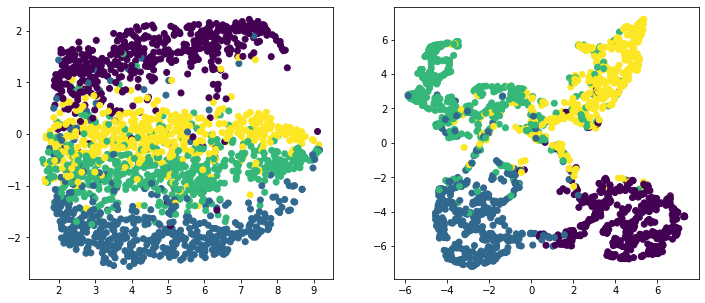

In [20]:
fig,ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].scatter(x[:,0], x[:,1], c=classes)
ax[1].scatter(x2[:,0], x2[:,1], c=classes)

In [21]:
mean_dr_logit = nbvae.lmb(z_loc, class_t).detach().numpy()

mean_dr_logit.shape

(4, 8, 2)

In [ ]:
nbvae.lmb.biases

In [ ]:
mean_dr_logit.shape, dr_means.shape

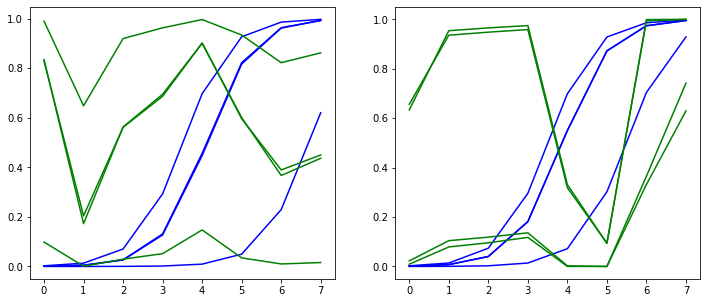

In [22]:
fig,ax = plt.subplots(1, n_drugs, figsize=(12, 5))

for i in range(n_drugs):
    ax[i].plot(ssp.expit(dr_means[:,:,i].T), color='b')
    ax[i].plot(ssp.expit(mean_dr_logit[:,:,i].T), color='g')

# plt.legend()
plt.show()